# Loading geodata tiff file

Here we will inspect visually the geodata that is downloaded by the `bioscann` pipeline via api request, and visualize the different data channels.

Load the required packages:

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tifffile import imsave, imread
import json, os, math

Define the target folder:

In [12]:
target_folder = 'data/processed_geodata/boreal_south/boreal_south_geodata'

Load the names of the downloaded data channels from the metadata json file:

In [13]:
with open(os.path.join(target_folder,'channel_info.json'), 'r') as file:
    data = json.load(file)
keys = list(data.keys())
print(keys)


['treeheight', 'soil_moisture', 'elevation_gradient', 'max_temp', 'sum_temp', 'ditches', 'peat_depth', 'soil_type', 'biomass', 'leaves_present', 'satellite']


Load the tiff file containing the geodata for one of the training instances:

In [14]:
geodata_file = os.path.join(target_folder,'indata/bboxes_0_5.tiff')
image = imread(geodata_file)
image.shape

(128, 128, 11)

In [15]:
geodata_file = "predictions/boreal_south_40,20,10,20,40_single_core/input/input_0.tiff"
image = imread(geodata_file)
image.shape

(128, 128, 11)

Display the content of the geodata tiff-file:

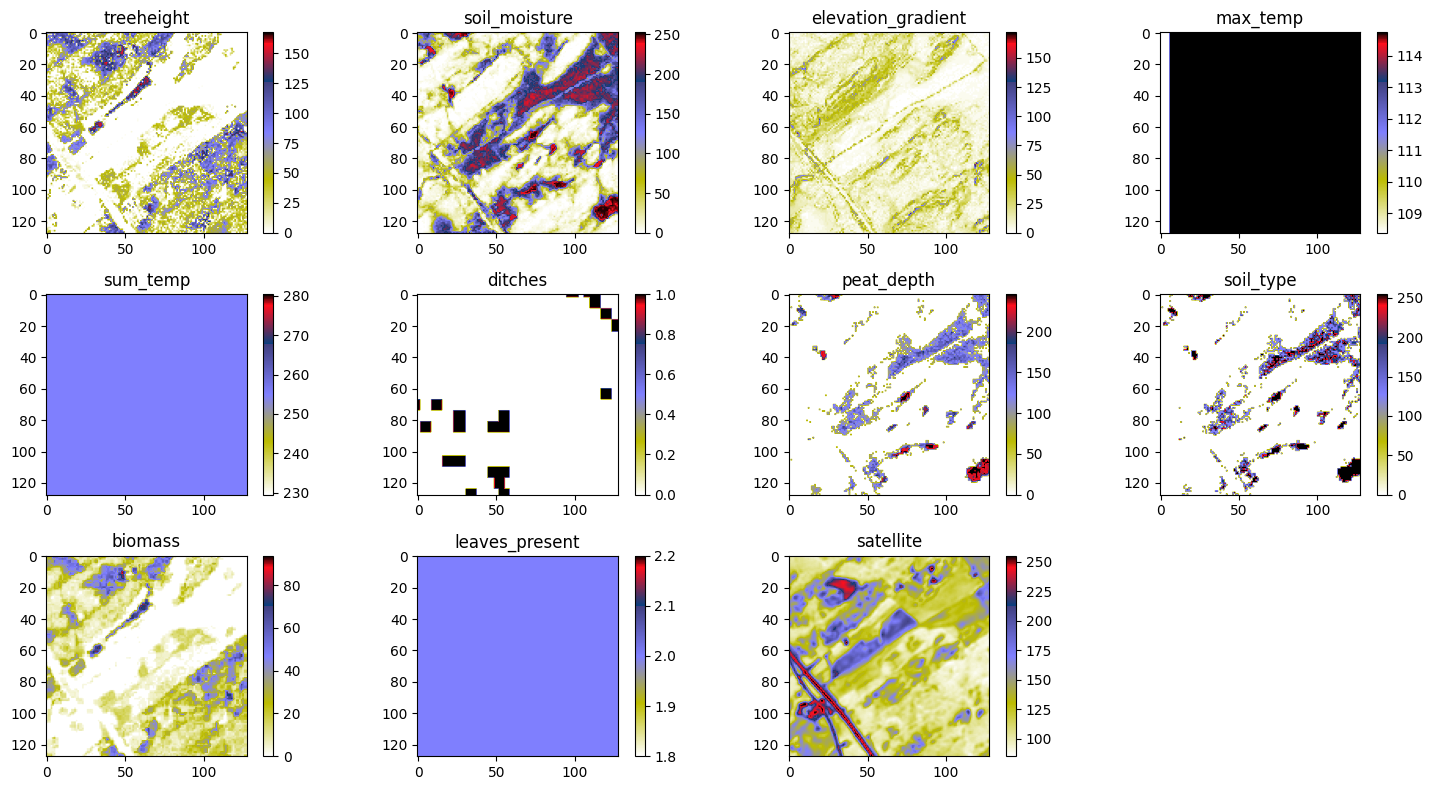

In [16]:
# Calculating the number of rows and columns for the subplots
n_channels = len(keys)
n_cols = int(math.ceil(math.sqrt(n_channels)))
n_rows = int(math.ceil(n_channels / n_cols))

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))

# Flatten axes array if necessary
axes = axes.ravel() if n_channels > 1 else [axes]

# Loop through each channel
for i in range(n_channels):
    ax = axes[i]
    im = ax.imshow(image[..., i], cmap='gist_stern_r')  # Change colormap as needed
    fig.colorbar(im, ax=ax)  # Add colorbar for each subplot
    ax.set_title(keys[i])

# Turn off any unused subplots
for j in range(n_channels, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

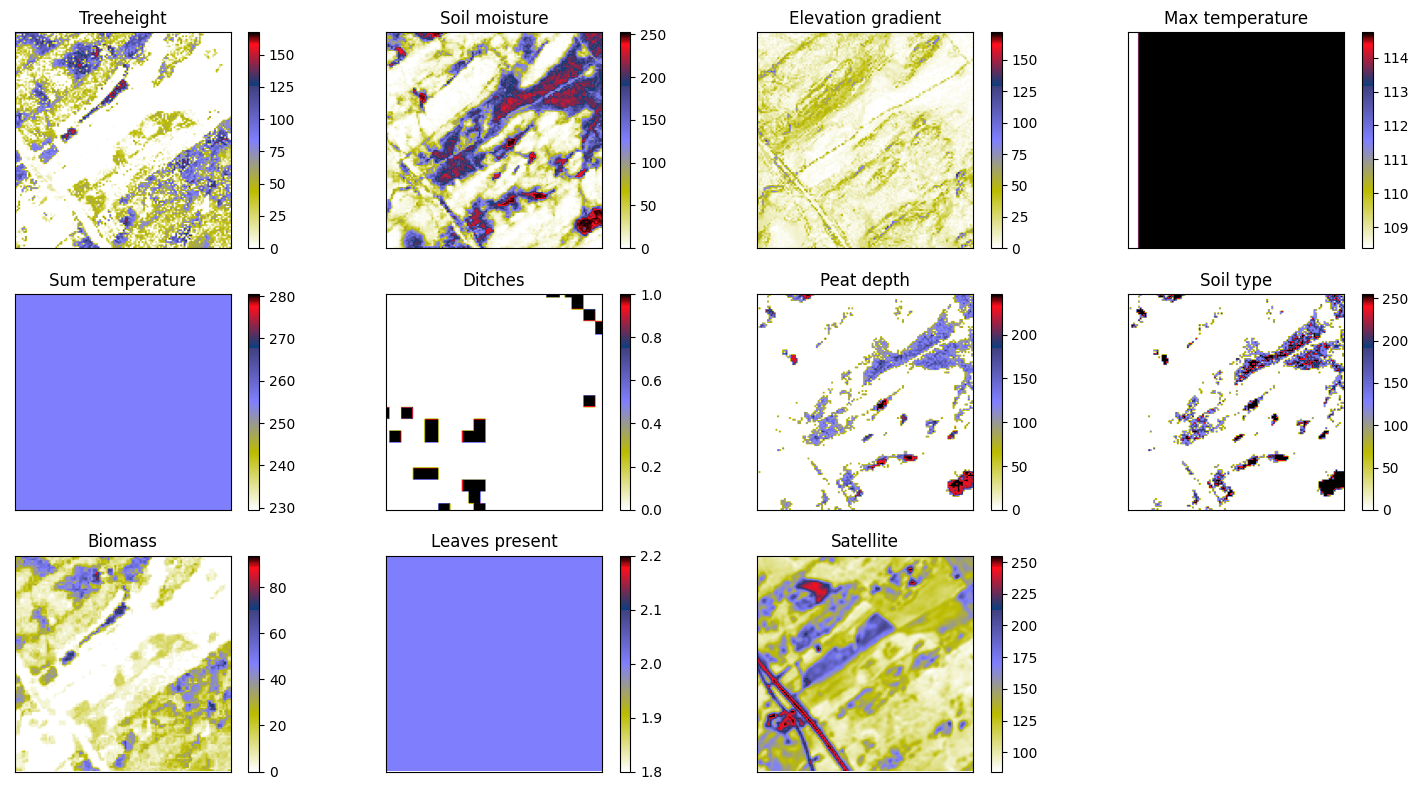

In [21]:
import math
import matplotlib.pyplot as plt

# Assuming 'keys' and 'image' are defined somewhere in your code
# For example:
# keys = ['temp_channel1', 'temp_channel2', ...]
# image = your_image_data

# Calculating the number of rows and columns for the subplots
n_channels = len(keys)
n_cols = int(math.ceil(math.sqrt(n_channels)))
n_rows = int(math.ceil(n_channels / n_cols))

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.01, hspace=0.01)  # Adjust these values as needed

# Flatten axes array if necessary
axes = axes.ravel() if n_channels > 1 else [axes]

# Loop through each channel
for i in range(n_channels):
    ax = axes[i]
    im = ax.imshow(image[..., i], cmap='gist_stern_r')  # Change colormap as needed
    fig.colorbar(im, ax=ax)  # Add colorbar for each subplot
    
    # Remove ticks and tick labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Update title, capitalize first word and replace underscores with spaces
    # Also replace 'temp' with 'temperature'
    title = keys[i].replace('_', ' ').replace('temp', 'temperature').capitalize()
    ax.set_title(title)

# Turn off any unused subplots
for j in range(n_channels, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Along with each geodata tiff there is also a mask produced by the `bioscann` pipeline, which shows which pixels of the selected area we have annotated data for (low or high conservation value forest information):

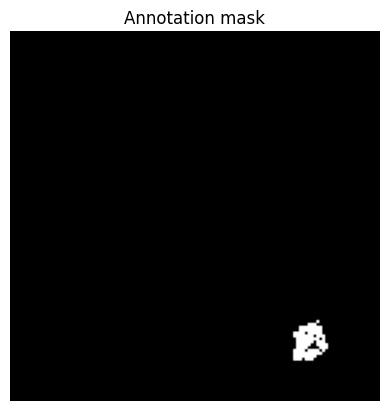

In [17]:
mask_path = geodata_file.replace('.tiff','_mask.tiff')
image = imread(mask_path)
plt.imshow(image, cmap='Greys_r')
plt.title('Annotation mask')
#plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

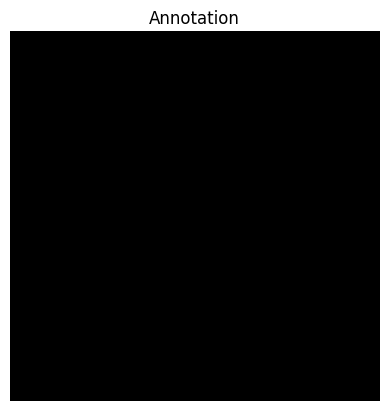

In [22]:
annotation_path = geodata_file.replace('indata','outdata')
image = imread(annotation_path)
plt.imshow(image, cmap='Greys_r')
plt.title('Annotation')
#plt.colorbar()
plt.axis('off')  # To hide axis values
plt.show()

In [91]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def count_pixels(indata_folder, outdata_folder):
    class_a_count = 0  # mask=1, bbox=1
    class_b_count = 0  # mask=1, bbox=0
    class_invalid_count = 0  # mask=0

    for filename in os.listdir(indata_folder):
        if "_mask.tiff" in filename:
            mask_path = os.path.join(indata_folder, filename)
            bbox_path = os.path.join(outdata_folder, filename.replace("_mask", ""))

            if os.path.exists(bbox_path):
                mask = np.array(Image.open(mask_path)).round().astype(int)
                bbox = np.array(Image.open(bbox_path)).round().astype(int)

                class_a_count += np.sum((mask == 255) & (bbox == 255))
                class_b_count += np.sum((mask == 255) & (bbox == 0))
                class_invalid_count += np.sum(mask == 0)

    return class_a_count, class_b_count, class_invalid_count

def plot_instance(instance_id, indata_folder, outdata_folder):
    mask_path = os.path.join(indata_folder, f"bboxes_{instance_id}_mask.tiff")
    bbox_path = os.path.join(outdata_folder, f"bboxes_{instance_id}.tiff")

    mask = np.array(Image.open(mask_path)).round().astype(int)
    bbox = np.array(Image.open(bbox_path)).round().astype(int)
    
    # Combined image: class A = 1, class B = 0, class_invalid = 2
    combined = np.zeros_like(mask)
    combined[(mask == 255) & (bbox == 255)] = 1  # class A
    combined[(mask == 255) & (bbox == 0)] = 0  # class B
    combined[mask == 0] = 2  # class_invalid

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    plt.subplot(1, 3, 2)
    plt.imshow(bbox, cmap='gray')
    plt.title('BBox')

    plt.subplot(1, 3, 3)
    plt.imshow(combined, cmap='viridis', vmin=0, vmax=2)
    plt.title('Combined (A=1, B=0, Invalid=2)')

    plt.show()
    return combined



Class A pixels: 6166258, Class B pixels: 2695165, Class Invalid pixels: 69896465


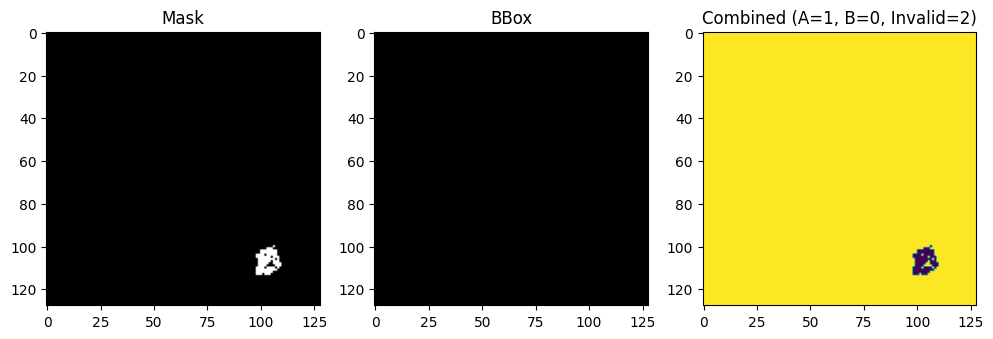

In [85]:
# Example usage
indata_folder = 'data/processed_geodata/alpine/alpine_geodata/indata'
outdata_folder = 'data/processed_geodata/alpine/alpine_geodata/outdata'
class_a_count, class_b_count, class_invalid_count = count_pixels(indata_folder, outdata_folder)
print(f"Class A pixels: {class_a_count}, Class B pixels: {class_b_count}, Class Invalid pixels: {class_invalid_count}")
# To plot for a specific instance
plot_instance("0_0", indata_folder, outdata_folder)


In [28]:
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
instance_id='0_0'
mask_path = os.path.join(indata_folder, f"bboxes_{instance_id}_mask.tiff")
bbox_path = os.path.join(outdata_folder, f"bboxes_{instance_id}.tiff")

mask = np.array(Image.open(mask_path))
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
mask.round().astype(int)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
indata_folder

'data/processed_geodata/alpine/alpine_geodata/indata'

In [70]:
class_a_count = 0  # mask=1, bbox=1
class_b_count = 0  # mask=1, bbox=0
class_invalid_count = 0  # mask=0

for filename in os.listdir(indata_folder):
    if "_mask.tiff" in filename:
        print(filename)
        break
        # mask_path = os.path.join(indata_folder, filename)
        # bbox_path = os.path.join(outdata_folder, filename.replace("_mask", ""))

        # if os.path.exists(bbox_path):
        #     mask = np.array(Image.open(mask_path)).round().astype(int)
        #     bbox = np.array(Image.open(bbox_path)).round().astype(int)

        #     class_a_count += np.sum((mask == 1) & (bbox == 1))
        #     class_b_count += np.sum((mask == 1) & (bbox == 0))
        #     class_invalid_count += np.sum(mask == 0)


bboxes_10_77_mask.tiff


In [71]:
mask_path = os.path.join(indata_folder, filename)
bbox_path = os.path.join(outdata_folder, filename.replace("_mask", ""))

if os.path.exists(bbox_path):
    mask = np.array(Image.open(mask_path)).round().astype(int)
    bbox = np.array(Image.open(bbox_path)).round().astype(int)

    class_a_count += np.sum((mask == 1) & (bbox == 1))
    class_b_count += np.sum((mask == 1) & (bbox == 0))
    class_invalid_count += np.sum(mask == 0)

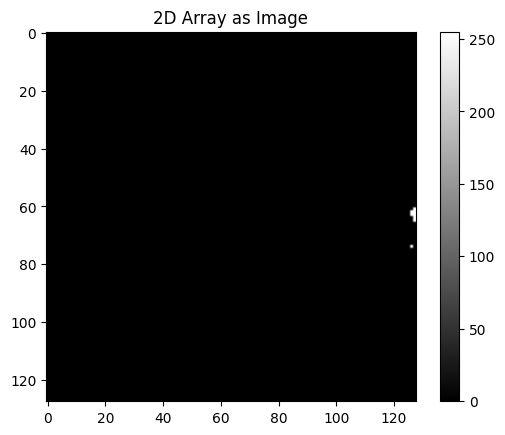

In [72]:
plt.imshow(mask, cmap='gray')  # 'cmap' is the color map, 'gray' is commonly used for single-channel images
plt.colorbar()  # Adds a colorbar to the plot to show the mapping of data values to colors
plt.title('2D Array as Image')
plt.show()

In [78]:
np.max(mask)

255

In [77]:
np.sum(mask)

2040

In [67]:
bbox

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [63]:
class_a_count

0

In [64]:
class_b_count

0

In [65]:
class_invalid_count

16376

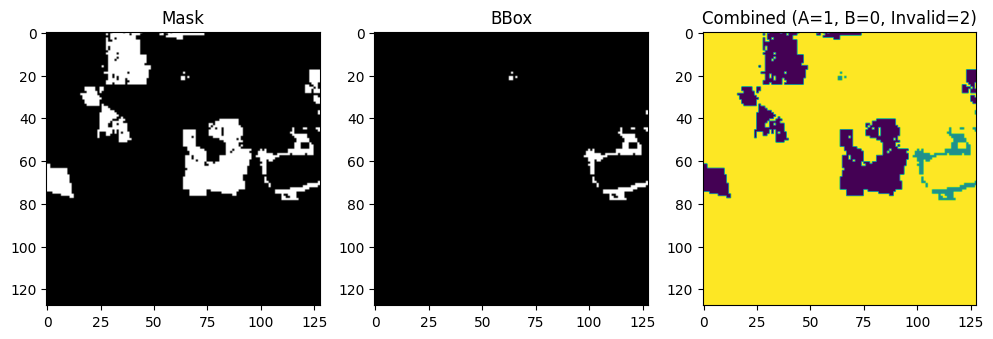

In [92]:
# Example usage
indata_folder = 'data/processed_geodata/boreal_south/boreal_south_geodata/indata'
outdata_folder = 'data/processed_geodata/boreal_south/boreal_south_geodata/outdata'
#class_a_count, class_b_count, class_invalid_count = count_pixels(indata_folder, outdata_folder)
#print(f"Class A pixels: {class_a_count}, Class B pixels: {class_b_count}, Class Invalid pixels: {class_invalid_count}")
# To plot for a specific instance
a = plot_instance("23_44", indata_folder, outdata_folder)


In [93]:
a

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

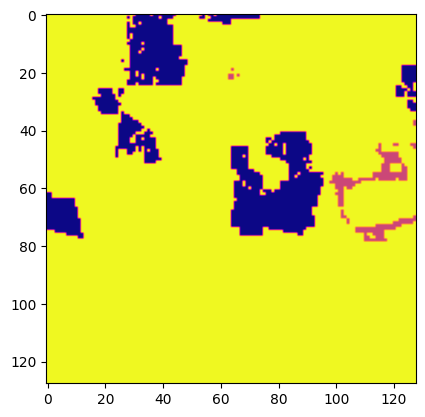

In [95]:
plt.imshow(a, cmap='plasma', vmin=0, vmax=2)